In [1]:
import os

os.chdir("..")
# print(os.getcwd()) 

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from Models import Generators, Discriminators, LossFunctions

In [4]:
df = pd.read_csv("Data/Maternal Health Risk Data Set.csv")
df = df.dropna()
numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
df = df[numeric_cols]

scaler = MinMaxScaler()
data = scaler.fit_transform(df)  # Normalizar datos entre 0 y 1
data_dim = data.shape[1]

In [5]:
# Initialize generator
generator = Generators.EncoderDecoderGenerator(in_out_dim=data_dim, latent_dim=16)
optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)

In [6]:
# Initialize discriminator
discriminator = Discriminators.Discriminator(input_dim=data_dim)
optimizer_d = optim.Adam(discriminator.parameters(), lr=1e-3)

# Loss function
criterion = nn.BCELoss()

In [7]:
t0 = time.time()

num_epochs = 8000
batch_size = 64

all_real_data_torch = torch.tensor(data, dtype=torch.float32)

save_nn_data_list = []
for epoch in range(num_epochs):
    
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data_array = data[idx]
    real_data = torch.tensor(data[idx], dtype=torch.float32)
    
    # Generar datos falsos
    z = torch.randn(batch_size, data_dim)
    fake_data = generator(z)

    if torch.any(torch.isnan(fake_data)) or torch.any(torch.isinf(fake_data)):
        print("Fake data contains NaNs or Infs!")
        break

    if torch.any(torch.isnan(real_data)) or torch.any(torch.isinf(real_data)):
        print("Real data contains NaNs or Infs!")
        break
    
    # Entrenar Discriminador
    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
    fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Entrenar Generador
    optimizer_g.zero_grad()
    g_loss = LossFunctions.custom_loss(fake_data, all_real_data_torch, method="median-iqr-covmat")
    g_loss.backward()
    # g_loss.backward()
    optimizer_g.step()

    if epoch % 100 == 0:
        save_nn_data_list.append({
            "epoch": epoch,
            "discriminator_loss": d_loss.item(),
            "generator_loss": g_loss.item()
        })

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

print(f"Epoch {epoch + 1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

df_nn = pd.DataFrame(save_nn_data_list)

training_time = time.time() - t0

print("Training time", np.round((training_time)/60, 4), "min")

Epoch 0, D Loss: 1.868091106414795, G Loss: 2.7513134479522705
Epoch 500, D Loss: 1.234066367149353, G Loss: 1.2733088731765747
Epoch 1000, D Loss: 0.8620976209640503, G Loss: 0.5738668441772461
Epoch 1500, D Loss: 0.3867933750152588, G Loss: 0.4766588807106018
Epoch 2000, D Loss: 0.2736862003803253, G Loss: 0.4791560769081116
Epoch 2500, D Loss: 0.19571706652641296, G Loss: 0.35257452726364136
Epoch 3000, D Loss: 0.19186823070049286, G Loss: 0.29820716381073
Epoch 3500, D Loss: 0.21853625774383545, G Loss: 0.33860674500465393
Epoch 4000, D Loss: 0.26077499985694885, G Loss: 0.2417011857032776
Epoch 4500, D Loss: 0.19832728803157806, G Loss: 0.3135393559932709
Epoch 5000, D Loss: 0.15773528814315796, G Loss: 0.43011176586151123
Epoch 5500, D Loss: 0.09711223840713501, G Loss: 0.2648881673812866
Epoch 6000, D Loss: 0.2676435112953186, G Loss: 0.27110356092453003
Epoch 6500, D Loss: 0.1524302065372467, G Loss: 0.32686173915863037
Epoch 7000, D Loss: 0.10555505007505417, G Loss: 0.2586193

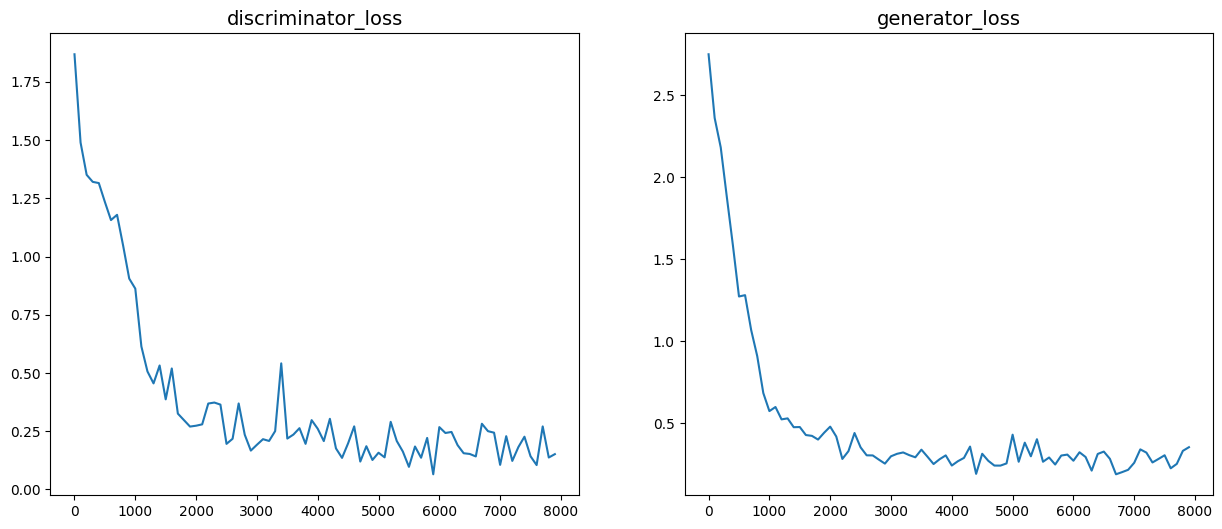

In [8]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1,2,1)
plt.plot(df_nn["epoch"], df_nn["discriminator_loss"])
plt.title("discriminator_loss", fontsize=14)

fig.add_subplot(1,2,2)
plt.plot(df_nn["epoch"], df_nn["generator_loss"])
plt.title("generator_loss", fontsize=14)

plt.show()

In [ ]:
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality

numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
sdv_metadata = SingleTableMetadata()
sdv_metadata.detect_from_dataframe(data=df[numeric_cols])
print(sdv_metadata.to_dict())

{'columns': {'Age': {'sdtype': 'numerical'}, 'SystolicBP': {'sdtype': 'numerical'}, 'DiastolicBP': {'sdtype': 'numerical'}, 'BS': {'sdtype': 'numerical'}, 'BodyTemp': {'sdtype': 'numerical'}, 'HeartRate': {'sdtype': 'numerical'}}, 'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1'}


In [ ]:
custom_metadata_dict = {
    "Age": "integer",
    "SystolicBP": "integer",
    "DiastolicBP": "integer",
    "BS": "float",
    "BodyTemp": "float",
    "HeartRate": "integer",
}

z = torch.randn(500, data_dim)  # Generar 5000 nuevas filas
synthetic_data = generator(z).detach().numpy()

# Denormalizar
synthetic_data = scaler.inverse_transform(synthetic_data)

# Guardar en CSV
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
# synthetic_df.to_csv("datos_sinteticos.csv", index=False)


custom_syn_df = synthetic_df.copy()

for col_name, col_type in custom_metadata_dict.items():
    if col_type == "integer":
        custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)

In [28]:
display(custom_syn_df)

corr_list = []
for i_c, i_col in enumerate(numeric_cols[:-1]):
    for j_col in numeric_cols[(i_c+1):]:
        corr_v, p_value = sp.stats.pearsonr(custom_syn_df[i_col].values, custom_syn_df[j_col].values)
        corr_list.append({
            "Feature1": i_col, "Feature2": j_col, "correlation": corr_v, "pvalue": p_value
        })

df_corr = pd.DataFrame(corr_list).sort_values("correlation", ascending=False).reset_index(drop=True)
df_corr

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,16,127,85,7.146350,98.001945,76
1,34,108,71,8.053351,98.016655,63
2,16,115,77,7.189338,98.002922,67
3,14,114,78,7.019393,98.008499,74
4,22,129,93,7.923916,98.003952,63
...,...,...,...,...,...,...
495,29,130,88,8.499685,98.008766,73
496,43,130,92,7.540627,98.003304,75
497,23,110,72,7.168002,98.005432,61
498,15,117,74,7.153940,98.003883,74


,Feature1,Feature2,correlation,pvalue
0,SystolicBP,DiastolicBP,0.892678,1.720249e-174
1,SystolicBP,BS,0.721448,1.634932e-81
2,Age,BS,0.669971,1.994821e-66
3,DiastolicBP,BS,0.564286,2.216629e-43
4,Age,SystolicBP,0.556488,5.363157e-42
5,Age,DiastolicBP,0.470891,5.855147e-29
6,BS,HeartRate,0.254465,7.879088e-09
7,Age,HeartRate,0.150254,7.502420e-04
8,Age,BodyTemp,-0.014698,7.430166e-01
9,DiastolicBP,HeartRate,-0.041265,3.571536e-01


In [35]:
quality_report = evaluate_quality(
    df[numeric_cols],
    synthetic_df,
    sdv_metadata
)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 38.99it/s]


Overall Quality Score: 82.08%

Properties:
Column Shapes: 70.39%
Column Pair Trends: 93.78%


In [37]:
quality_report.get_score()

0.8243154662504308

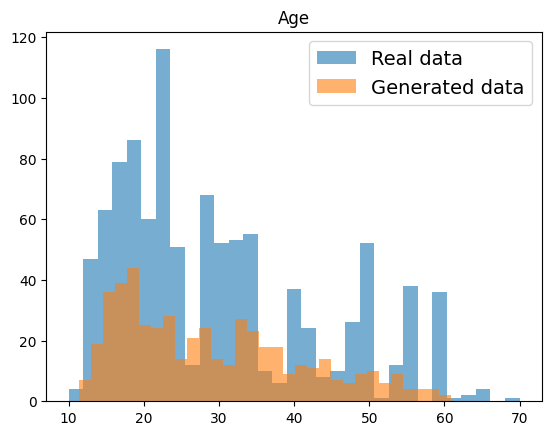

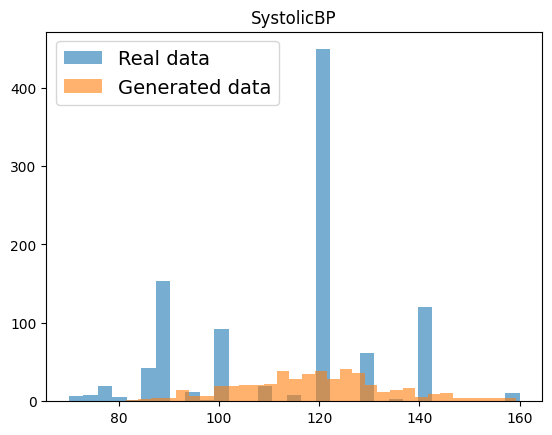

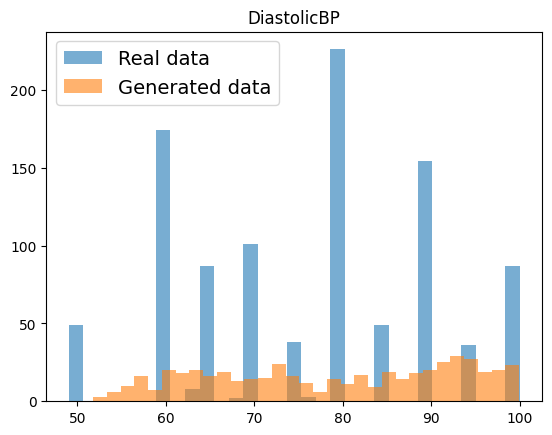

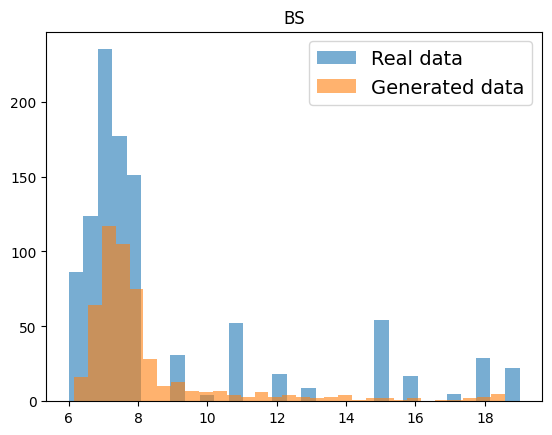

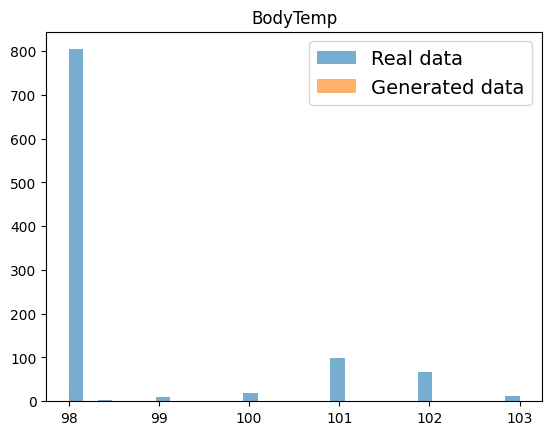

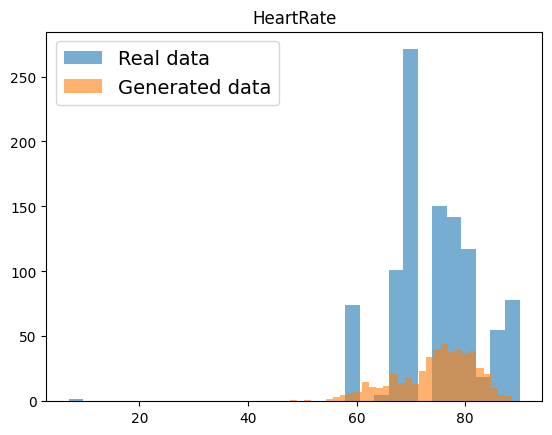

In [38]:
for col in numeric_cols:

    plt.hist(df[col].values, bins=31, alpha=0.6, label="Real data")
    plt.hist(synthetic_df[col].values, bins=31, alpha=0.6, label="Generated data")
    plt.title(col, fontsize=12)
    plt.legend(fontsize=14)
    
    plt.show()

# Make a loop

In [48]:
import itertools
from collections import defaultdict

import sklearn.metrics as skm

from sdv.single_table import GaussianCopulaSynthesizer

In [49]:
def generate_combinations(elements, sizes):
    comb_list = []
    for size in sizes:
        comb_list.extend(list(itertools.combinations(elements, size)))
    return comb_list

In [50]:
loss_method = ["median", "iqr", "autocorr", "corrmat", "covmat"]
sizes = np.arange(2, 3+1)
all_comb_list = generate_combinations(loss_method, sizes)
loss_method_list = ["-".join(x) for x in all_comb_list]
loss_method_list.extend(loss_method + ["all"])
print(loss_method_list)
print("Number of methods", len(loss_method_list))

['median-iqr', 'median-autocorr', 'median-corrmat', 'median-covmat', 'iqr-autocorr', 'iqr-corrmat', 'iqr-covmat', 'autocorr-corrmat', 'autocorr-covmat', 'corrmat-covmat', 'median-iqr-autocorr', 'median-iqr-corrmat', 'median-iqr-covmat', 'median-autocorr-corrmat', 'median-autocorr-covmat', 'median-corrmat-covmat', 'iqr-autocorr-corrmat', 'iqr-autocorr-covmat', 'iqr-corrmat-covmat', 'autocorr-corrmat-covmat', 'median', 'iqr', 'autocorr', 'corrmat', 'covmat', 'all']
Number of methods 26


In [ ]:
from sdv.metadata import SingleTableMetadata

sdv_metadata = SingleTableMetadata()
sdv_metadata.detect_from_dataframe(data=df)

In [51]:
def post_process_data_with_metadata(data, custom_metadata_dict):
    custom_syn_df = data.copy()
    for col_name, col_type in custom_metadata_dict.items():
        if col_type == "integer":
            custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)

    return custom_syn_df

In [61]:
def generate_synthetic_data(generator, scaler, df_columns, num_data_generate, data_dim):
    """Generates synthetic data using a GAN-based generator and denormalizes it."""
    z = torch.randn(num_data_generate, data_dim)
    synthetic_data = generator(z).detach().numpy()
    synthetic_data_denom = scaler.inverse_transform(synthetic_data)
    return pd.DataFrame(synthetic_data_denom, columns=df_columns)

def evaluate_generator_metrics(real_df, synthetic_df, metadata=sdv_metadata):
    """Evaluates synthetic data quality using a quality report."""
    quality_report = evaluate_quality(real_df, synthetic_df, metadata, verbose=False)
    return quality_report.get_score()

def evaluate_discriminator_metrics(discriminator, real_data, fake_data, sigmoid_th, metrics_skm_dict):
    """Evaluates discriminator performance using real and synthetic data."""
    both_data_torch = torch.cat((real_data, fake_data), dim=0)
    
    true_labels = np.concatenate((np.zeros(real_data.shape[0]), np.ones(fake_data.shape[0])))
    discriminator_score = discriminator(both_data_torch)
    
    disc_score_array = (discriminator_score.detach().numpy()[:, 0] > sigmoid_th).astype(int)

    return {k: skm_func(true_labels, disc_score_array) for k, skm_func in metrics_skm_dict.items()}

def generate_sdv_synthetic_data(df, num_data_generate, metadata=sdv_metadata):
    """Generates synthetic data using SDV GaussianCopulaSynthesizer."""
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(data=df)
    return synthesizer.sample(num_rows=num_data_generate)

In [ ]:
metrics_skm_dict = {
    "accuracy": skm.accuracy_score,
    "kappa": skm.cohen_kappa_score,
    "f1_score": skm.f1_score
}

num_epochs = 100
batch_size = 64
num_generate_th = 30
num_data_generate = 500
sigmoid_th = 0.5

save_result_list = []

for loss_method in loss_method_list[:]:

    print(loss_method)
    
    all_real_data_torch = torch.tensor(data, dtype=torch.float32)

    generator = Generators.EncoderDecoderGenerator(in_out_dim=data_dim, latent_dim=16)
    optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)
    
    discriminator = Discriminators.Discriminator(input_dim=data_dim)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=1 * 10 ** -4)
    
    criterion = nn.BCELoss()
    
    for epoch in range(num_epochs):
        
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data_array = data[idx]
        real_data = torch.tensor(data[idx], dtype=torch.float32)
        
        # Generar datos falsos
        z = torch.randn(batch_size, data_dim)
        fake_data = generator(z)
    
        if torch.any(torch.isnan(fake_data)) or torch.any(torch.isinf(fake_data)):
            print("Fake data contains NaNs or Infs!")
            break
    
        if torch.any(torch.isnan(real_data)) or torch.any(torch.isinf(real_data)):
            print("Real data contains NaNs or Infs!")
            break
        
        # Entrenar Discriminador
        optimizer_d.zero_grad()
        real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
        fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()
    
        # Entrenar Generador
        optimizer_g.zero_grad()
        g_loss = LossFunctions.custom_loss(fake_data, all_real_data_torch, method=loss_method)
        g_loss.backward()
        # g_loss.backward()
        optimizer_g.step()

    # #####################
    # ### Generate data ###
    # #####################
    metrics_dict = defaultdict(list)
    for _ in range(num_generate_th):
        # ########################
        # ### Custom Generator ###
        # ########################
        # Generate and process GAN-based synthetic data
        synthetic_df = generate_synthetic_data(generator, scaler, df.columns, num_data_generate, data_dim)
        custom_syn_df = post_process_data_with_metadata(synthetic_df, custom_metadata_dict)

        # Generator Metrics
        qr_score = evaluate_generator_metrics(df[numeric_cols], custom_syn_df)
        metrics_dict["qr_score"].append(qr_score)

        # Discriminator Metrics
        real_data_tensor = torch.tensor(data[np.random.randint(0, data.shape[0], num_data_generate)], dtype=torch.float32)
        fake_data_tensor = torch.tensor(synthetic_df.values, dtype=torch.float32)
        
        disc_metrics = evaluate_discriminator_metrics(discriminator, real_data_tensor, fake_data_tensor, sigmoid_th, metrics_skm_dict)
        for k, v in disc_metrics.items():
            metrics_dict[k].append(v)

        # #####################
        # ### SDV Generator ###
        # #####################
        # Generate and process SDV-based synthetic data
        synthetic_df_sdv = generate_sdv_synthetic_data(df, num_data_generate)

        # Generator Metrics for SDV
        qr_score_sdv = evaluate_generator_metrics(df[numeric_cols], synthetic_df_sdv)
        metrics_dict["sdv_qr_score"].append(qr_score_sdv)

        # Discriminator Metrics for SDV
        fake_data_tensor_sdv = torch.tensor(synthetic_df_sdv.values, dtype=torch.float32)
        disc_metrics_sdv = evaluate_discriminator_metrics(discriminator, real_data_tensor, fake_data_tensor_sdv, sigmoid_th, metrics_skm_dict)
        for k, v in disc_metrics_sdv.items():
            metrics_dict[f"sdv_{k}"].append(v)

    del generator, discriminator, optimizer_g, optimizer_d, criterion
    
    dict_help = {"loss_method": loss_method}
    for k, v in metrics_dict.items():
        dict_help[f"mean_{k}"] = np.mean(v)
        if k != "sdv_qr_score": 
            dict_help[f"std_{k}"] = np.std(v)
        
    save_result_list.append(dict_help)

median-iqr
median-autocorr
median-corrmat
median-covmat
iqr-autocorr
iqr-corrmat
iqr-covmat
autocorr-corrmat
autocorr-covmat
corrmat-covmat
median-iqr-autocorr
median-iqr-corrmat
median-iqr-covmat
median-autocorr-corrmat
median-autocorr-covmat
median-corrmat-covmat
iqr-autocorr-corrmat
iqr-autocorr-covmat
iqr-corrmat-covmat
autocorr-corrmat-covmat
median
iqr
autocorr
corrmat
covmat
all


In [63]:
df_results = pd.DataFrame(save_result_list).sort_values("mean_qr_score", ascending=False).reset_index(drop=True)
df_results.head(10)

,loss_method,mean_qr_score,std_qr_score,mean_accuracy,std_accuracy,mean_kappa,std_kappa,mean_f1_score,std_f1_score,mean_sdv_qr_score,std_sdv_qr_score,mean_sdv_accuracy,std_sdv_accuracy,mean_sdv_kappa,std_sdv_kappa,mean_sdv_f1_score,std_sdv_f1_score
0,median-autocorr-corrmat,0.681943,0.003082,0.515633,0.014992,0.031267,0.029984,0.563636,0.017279,0.848438,1.110223e-16,0.492667,0.014517,-0.014667,0.029035,0.541970,0.015597
1,iqr-corrmat,0.675567,0.002586,0.527833,0.016503,0.055667,0.033005,0.499395,0.018329,0.848438,1.110223e-16,0.540233,0.013381,0.080467,0.026762,0.512935,0.015788
2,median-corrmat,0.669871,0.003436,0.507233,0.017399,0.014467,0.034797,0.525097,0.016991,0.848438,1.110223e-16,0.502167,0.015386,0.004333,0.030773,0.520270,0.015355
3,corrmat-covmat,0.662935,0.003162,0.494267,0.015682,-0.011467,0.031364,0.579615,0.013802,0.848438,1.110223e-16,0.470633,0.014725,-0.058733,0.029450,0.560968,0.013395
4,median-corrmat-covmat,0.657277,0.003438,0.457833,0.016367,-0.084333,0.032734,0.565904,0.013522,0.848438,1.110223e-16,0.479467,0.012377,-0.041067,0.024753,0.583025,0.011229
5,corrmat,0.653612,0.002939,0.502167,0.013673,0.004333,0.027345,0.410091,0.017573,0.848438,1.110223e-16,0.511733,0.012827,0.023467,0.025654,0.416165,0.018433
6,iqr-corrmat-covmat,0.653206,0.002844,0.448433,0.013296,-0.103133,0.026592,0.404984,0.017183,0.848438,1.110223e-16,0.453500,0.014984,-0.093000,0.029968,0.413063,0.017240
7,median-iqr-corrmat,0.651016,0.003998,0.477267,0.017701,-0.045467,0.035402,0.345151,0.024686,0.848438,1.110223e-16,0.468133,0.015845,-0.063733,0.031689,0.335829,0.019588
8,autocorr-corrmat,0.647171,0.002180,0.525067,0.014473,0.050133,0.028946,0.404459,0.019271,0.848438,1.110223e-16,0.559233,0.017420,0.118467,0.034839,0.444422,0.025579
9,all,0.642441,0.002708,0.557267,0.014443,0.114533,0.028886,0.482574,0.018409,0.848438,1.110223e-16,0.543833,0.013062,0.087667,0.026123,0.464534,0.015514
